### PFSS Modeling Calculations

Tamar Ervin - September 26, 2022

Based off example notebook: Sam Badman - 8/25/22

This notebook goes through running a potential field source surface (PFSS, [1](https://ui.adsabs.harvard.edu/abs/1969SoPh....9..131A/abstract),[2](https://ui.adsabs.harvard.edu/abs/1969SoPh....6..442S/abstract)) model of the solar coronal magnetic field using pfsspy and accessing its components including tracing fieldlines, creating a map of coronal holes and flying a model spacecraft through it and tracing field line connections

Read more about pfsspy here : https://pfsspy.readthedocs.io/en/stable/ and view the source code here : https://github.com/dstansby/pfsspy/tree/0c5b78a2901c5dd55ddc286ba25a91717e85a40c

In [5]:
import astropy
import sunpy, sunpy.map
import pfsspy
import matplotlib.pyplot as plt
import numpy as np

import sys, os

sys.path.append(os.path.realpath(''))
# sys.path.append('/Users/tamarervin/Desktop/Repositories/mag_model/')
import utilities as utils
import psp_funcs as psp_funcs
import pfss_funcs as pfss_funcs
import pandas as pd
import astropy.units as u

In [6]:
rss_values = np.arange(2.0, 3.75, 0.25)
IMG_DIR = os.path.realpath('../mag_model/images')
PSP_DATA_DIR = os.path.realpath('../mag_model/data/psp')
HCS_DATA_DIR = os.path.realpath('../mag_model/data/gong')


# Looking at PSP Data
- read in the PSP text file with timestamps and $\mathrm{B_r \, AU^2}$ values
- use to compare with data to find a 'best' magnetogram
- pull the polarity to overlay on the plot
- save lat, lon, and polarity values

In [13]:
# read in the PSP text file and convert to a pandas dataframe
import pandas as pd

psp_txt_file = '/Users/tamarervin/Desktop/Repositories/mag_model/data/psp/e14_br_predict.csv'
psp_data = pd.read_csv(psp_txt_file, names=['datetime', 'Br'], engine='python')

# split the datetime column into a separate date and time column
psp_data[['date', 'time']] = psp_data.datetime.str.split('/', expand=True)
dates = psp_data.date + 'T' + psp_data.time

# convert datetime to a JD date and datetime object -- use the conversion function in utilities.py
dates_list = [utils.get_dates(date) for date in dates]
jd_dates = [d[2] for d in dates_list]
jd_dates = [d.to_value('jd', 'long') for d in jd_dates]
psp_data['jd'] = jd_dates
psp_data['date_obj'] = [d[1] for d in dates_list]

# add a polarity column
psp_data['polarity'] = np.sign(psp_data.Br)

# remove the data from september 5 due to the solar flare -- set up a flag column
date_str, date_obj, date_jd = utils.get_dates('2022-09-05T00:00:00.000')
flag_inds = np.logical_and(psp_data.date >= date_jd - 0.2, psp_data.date <= date_jd + 1)
flag = np.array(['' for x in range(len(psp_data.datetime))])
flag[flag_inds] = 'flare'
psp_data['flag'] = flag



# Find the trajectory of PSP using astrospice and timestamps above

In [4]:
# get the corresponding coordinates to the timestamps in the dataframe
# psp_coords_carr = psp_funcs.get_psp_coords(psp_data.date_obj)
import astrospice

kernels = astrospice.registry.get_kernels('psp', 'predict')
psp_coords_inertial = astrospice.generate_coords('SOLAR PROBE PLUS', psp_data.date_obj)

# Transform to Heliographic Carrington, i.e. the frame that co-rotates with the Sun.
psp_coords_carr = psp_coords_inertial.transform_to(
sunpy.coordinates.HeliographicCarrington(observer="self"))

# get psp at source surface
psp_at_source_surface = psp_funcs.coord_projection(psp_coords_carr, rss, psp_data.date_obj)


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [5]:
# do the parker spiral projection to get the coordinates at the source surface for different source surface heights
from astropy.table import QTable
# create QTable with astropy
# t = QTable()
coords = pd.DataFrame()
for rss in rss_values:
    # get psp at source surface
    psp_at_source_surface = psp_funcs.coord_projection(psp_coords_carr, rss, psp_data.date_obj)

    # save these values with corresponding source surface height as column name to the data array
    coords['lon_' + str(int(rss*100))] = psp_at_source_surface.lon.degree
    coords['lat_' + str(int(rss*100))] = psp_at_source_surface.lat.degree


# savecsv = os.path.join(PSP_DATA_DIR, 'psp_ss.csv')
# t.to_csv(savecsv)  

# create $\mathrm{B_rR^2}$ map
- create the PFSS model for one magnetogram at perihelion 
- run the PSP trajectory over the PFSS model and trace the field lines back down to the source surface using parker spiral
- get the Br values at the source surface from the PFSS model

In [6]:
# get a magnetogram for the specific date and time in question
filenames = [
'adapt41311_03k012_202212230000_i00065600n1.fts.gz',
'adapt41311_03k012_202212240000_i00005500n1.fts.gz',
'adapt41311_03k012_202212250000_i00005600n1.fts.gz',
'adapt41311_03k012_202212260000_i00005600n1.fts.gz',
'adapt41311_03k012_202212270000_i00010600n1.fts.gz'
]
# filenames = ['adapt41311_03k012_202209170000_i00005600n1.fts.gz', 
# 'adapt41311_03k012_202209180000_i00005700n1.fts.gz', 'adapt40311_03k012_202209190000_i00005600n1.fts.gz', 
# 'adapt41311_03k012_202209200000_i00005600n1.fts.gz', 'adapt41311_03k012_202209210000_i00005600n1.fts.gz']	

#'adapt40311_03k012_202209190200_i00025600n1.fts.gz', 'adapt40311_03k012_202209190400_i00010500n1.fts.gz',
# 'adapt40311_03k012_202209190600_i00030500n1.fts.gz', 'adapt40311_03k012_202209190800_i00003600n1.fts.gz', 'adapt40311_03k012_202209191000_i00023600n1.fts.gz', 
# 'adapt40311_03k012_202209191200_i00043600n1.fts.gz', 'adapt40311_03k012_202209191400_i00005600n1.fts.gz', 'adapt40311_03k012_202209191600_i00005600n1.fts.gz', 


# create dataframe
hcs_data = []

In [7]:
for filename in filenames:

    # download magnetogram
    remote_path = "ftp://gong.nso.edu//adapt/maps/gong/2022"
    local_path = "data/gong"
    if not os.path.exists(f"{local_path}/{filename}") : # check if file has already been downloaded
        print(f"Downloading {local_path}/{filename}") 
        os.system(f'wget {remote_path}/{filename} -P {local_path}')
    else : print(f"{local_path}/{filename} already exists!" )

    # get an adapt magnetogram
    filepath = f"{local_path}/{filename}"
    adapt_magnetogram = pfss_funcs.adapt2pfsspy(filepath, return_magnetogram=True)

    # run pfss model for varying RSS values
    for rss in rss_values:
        # run the PFSS model with rss 
        pfss_model = pfss_funcs.adapt2pfsspy(filepath, rss)

        # magnetic field line tracing starting from photosphere
        flines = pfss_funcs.pfss2flines(pfss_model)

        # get Br at the source surface from the pfss model
        pfss_br = pfss_model.source_surface_br

        # get HCS
        hcs = [pfss_model.source_surface_pils[0].lon, pfss_model.source_surface_pils[0].lat]

        # add this to dataframe
        df_name = str(int(rss*100)) + "_" + str(pfss_br.date)
        hcs_df = pd.DataFrame({str(df_name) : hcs})
        hcs_data.append(hcs_df)


--2023-01-18 09:18:30--  ftp://gong.nso.edu//adapt/maps/gong/2022/adapt41311_03k012_202212230000_i00065600n1.fts.gz
           => ‘data/gong/adapt41311_03k012_202212230000_i00065600n1.fts.gz’
Resolving gong.nso.edu (gong.nso.edu)... 146.5.21.69
Connecting to gong.nso.edu (gong.nso.edu)|146.5.21.69|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /adapt/maps/gong/2022 ... done.
==> SIZE adapt41311_03k012_202212230000_i00065600n1.fts.gz ... 3127070
==> PASV ... done.    ==> RETR adapt41311_03k012_202212230000_i00065600n1.fts.gz ... done.
Length: 3127070 (3.0M) (unauthoritative)

     0K .......... .......... .......... .......... ..........  1%  470K 6s
    50K .......... .......... .......... .......... ..........  3% 1.52M 4s
   100K .......... .......... .......... .......... ..........  4% 22.3M 3s
   150K .......... .......... .......... .......... ..........  6% 57.7M 2s
   200K .......... .......... 

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


--2023-01-18 09:19:09--  ftp://gong.nso.edu//adapt/maps/gong/2022/adapt41311_03k012_202212240000_i00005500n1.fts.gz
           => ‘data/gong/adapt41311_03k012_202212240000_i00005500n1.fts.gz’
Resolving gong.nso.edu (gong.nso.edu)... 146.5.21.69
Connecting to gong.nso.edu (gong.nso.edu)|146.5.21.69|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /adapt/maps/gong/2022 ... done.
==> SIZE adapt41311_03k012_202212240000_i00005500n1.fts.gz ... 3128390
==> PASV ... done.    ==> RETR adapt41311_03k012_202212240000_i00005500n1.fts.gz ... done.
Length: 3128390 (3.0M) (unauthoritative)

     0K .......... .......... .......... .......... ..........  1%  449K 7s
    50K .......... .......... .......... .......... ..........  3% 1.47M 4s
   100K .......... .......... .......... .......... ..........  4% 16.6M 3s
   150K .......... .......... .......... .......... ..........  6% 79.3M 2s
   200K .......... .......... 

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


--2023-01-18 09:19:44--  ftp://gong.nso.edu//adapt/maps/gong/2022/adapt41311_03k012_202212250000_i00005600n1.fts.gz
           => ‘data/gong/adapt41311_03k012_202212250000_i00005600n1.fts.gz’
Resolving gong.nso.edu (gong.nso.edu)... 146.5.21.69
Connecting to gong.nso.edu (gong.nso.edu)|146.5.21.69|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /adapt/maps/gong/2022 ... done.
==> SIZE adapt41311_03k012_202212250000_i00005600n1.fts.gz ... 3127843
==> PASV ... done.    ==> RETR adapt41311_03k012_202212250000_i00005600n1.fts.gz ... done.
Length: 3127843 (3.0M) (unauthoritative)

     0K .......... .......... .......... .......... ..........  1%  515K 6s
    50K .......... .......... .......... .......... ..........  3% 1.45M 4s
   100K .......... .......... .......... .......... ..........  4% 75.7M 3s
   150K .......... .......... .......... .......... ..........  6% 64.8M 2s
   200K .......... .......... 

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


--2023-01-18 09:20:32--  ftp://gong.nso.edu//adapt/maps/gong/2022/adapt41311_03k012_202212260000_i00005600n1.fts.gz
           => ‘data/gong/adapt41311_03k012_202212260000_i00005600n1.fts.gz’
Resolving gong.nso.edu (gong.nso.edu)... 146.5.21.69
Connecting to gong.nso.edu (gong.nso.edu)|146.5.21.69|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /adapt/maps/gong/2022 ... done.
==> SIZE adapt41311_03k012_202212260000_i00005600n1.fts.gz ... 3127776
==> PASV ... done.    ==> RETR adapt41311_03k012_202212260000_i00005600n1.fts.gz ... done.
Length: 3127776 (3.0M) (unauthoritative)

     0K .......... .......... .......... .......... ..........  1%  539K 6s
    50K .......... .......... .......... .......... ..........  3% 1.56M 4s
   100K .......... .......... .......... .......... ..........  4% 17.7M 2s
   150K .......... .......... .......... .......... ..........  6% 29.1M 2s
   200K .......... .......... 

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


--2023-01-18 09:21:21--  ftp://gong.nso.edu//adapt/maps/gong/2022/adapt41311_03k012_202212270000_i00010600n1.fts.gz
           => ‘data/gong/adapt41311_03k012_202212270000_i00010600n1.fts.gz’
Resolving gong.nso.edu (gong.nso.edu)... 146.5.21.69
Connecting to gong.nso.edu (gong.nso.edu)|146.5.21.69|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /adapt/maps/gong/2022 ... done.
==> SIZE adapt41311_03k012_202212270000_i00010600n1.fts.gz ... 3128492
==> PASV ... done.    ==> RETR adapt41311_03k012_202212270000_i00010600n1.fts.gz ... done.
Length: 3128492 (3.0M) (unauthoritative)

     0K .......... .......... .......... .......... ..........  1%  425K 7s
    50K .......... .......... .......... .......... ..........  3% 1.50M 4s
   100K .......... .......... .......... .......... ..........  4% 57.0M 3s
   150K .......... .......... .......... .......... ..........  6% 31.6M 2s
   200K .......... .......... 

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


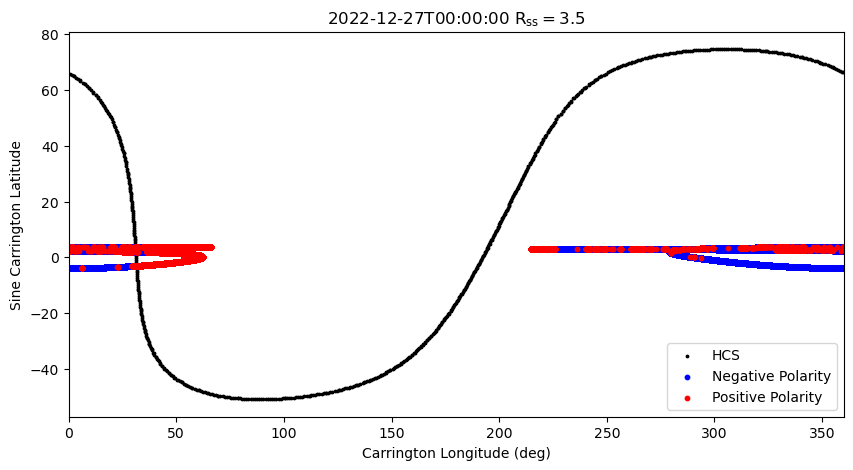

In [8]:
import astropy.units as u

# get Br at the source surface from the pfss model
pfss_br = pfss_model.source_surface_br

# get HCS
hcs = pfss_model.source_surface_pils[0]

# plot this using sunpy
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
# pfss_br.plot(axes=ax)

# plot the HCS
ax.scatter(hcs.lon, hcs.lat, color='black', s=3, label='HCS')

# plot the PSP trajectory on top of it
pos = np.where(psp_data.polarity == 1)
neg = np.where(psp_data.polarity == -1)

ax.scatter(psp_at_source_surface.lon[neg], psp_at_source_surface.lat[neg], color='blue', s=10,
label='Negative Polarity')
ax.scatter(psp_at_source_surface.lon[pos], psp_at_source_surface.lat[pos], color='red', s=10, 
label='Positive Polarity')

ax.set_title(str(pfss_br.date)[:-4] + r" $\rm R_{ss} =$" + str(rss))
ax.set_xlabel("Carrington Longitude (deg)")
ax.set_ylabel("Sine Carrington Latitude")

ax.set_xlim(0,360)
ax.legend(loc='lower right')

fig_title = str(pfss_br.date) + '_' + str(rss) + '.png'
figpath = os.path.join(IMG_DIR, fig_title)
fig.savefig(figpath, dpi=1200, bbox_inches='tight')

# Comparison Plotting

In [9]:
# do some comparison plotting:
# read in HCS CSV file
import pandas as pd
import matplotlib.pyplot as plt

# if using HCS data from CSV
# hcs_file = '/Users/tamarervin/Desktop/Repositories/mag_model/data/gong/hcs_data.csv'
# hcs = pd.read_csv(hcs_file, engine='python', index_col=0)

# # read in PSP CSV file
# psp_file = '/Users/tamarervin/Desktop/Repositories/mag_model/data/psp/psp_ss.csv'
# psp = pd.read_csv(psp_file, engine='python', delimiter=',', index_col=0)


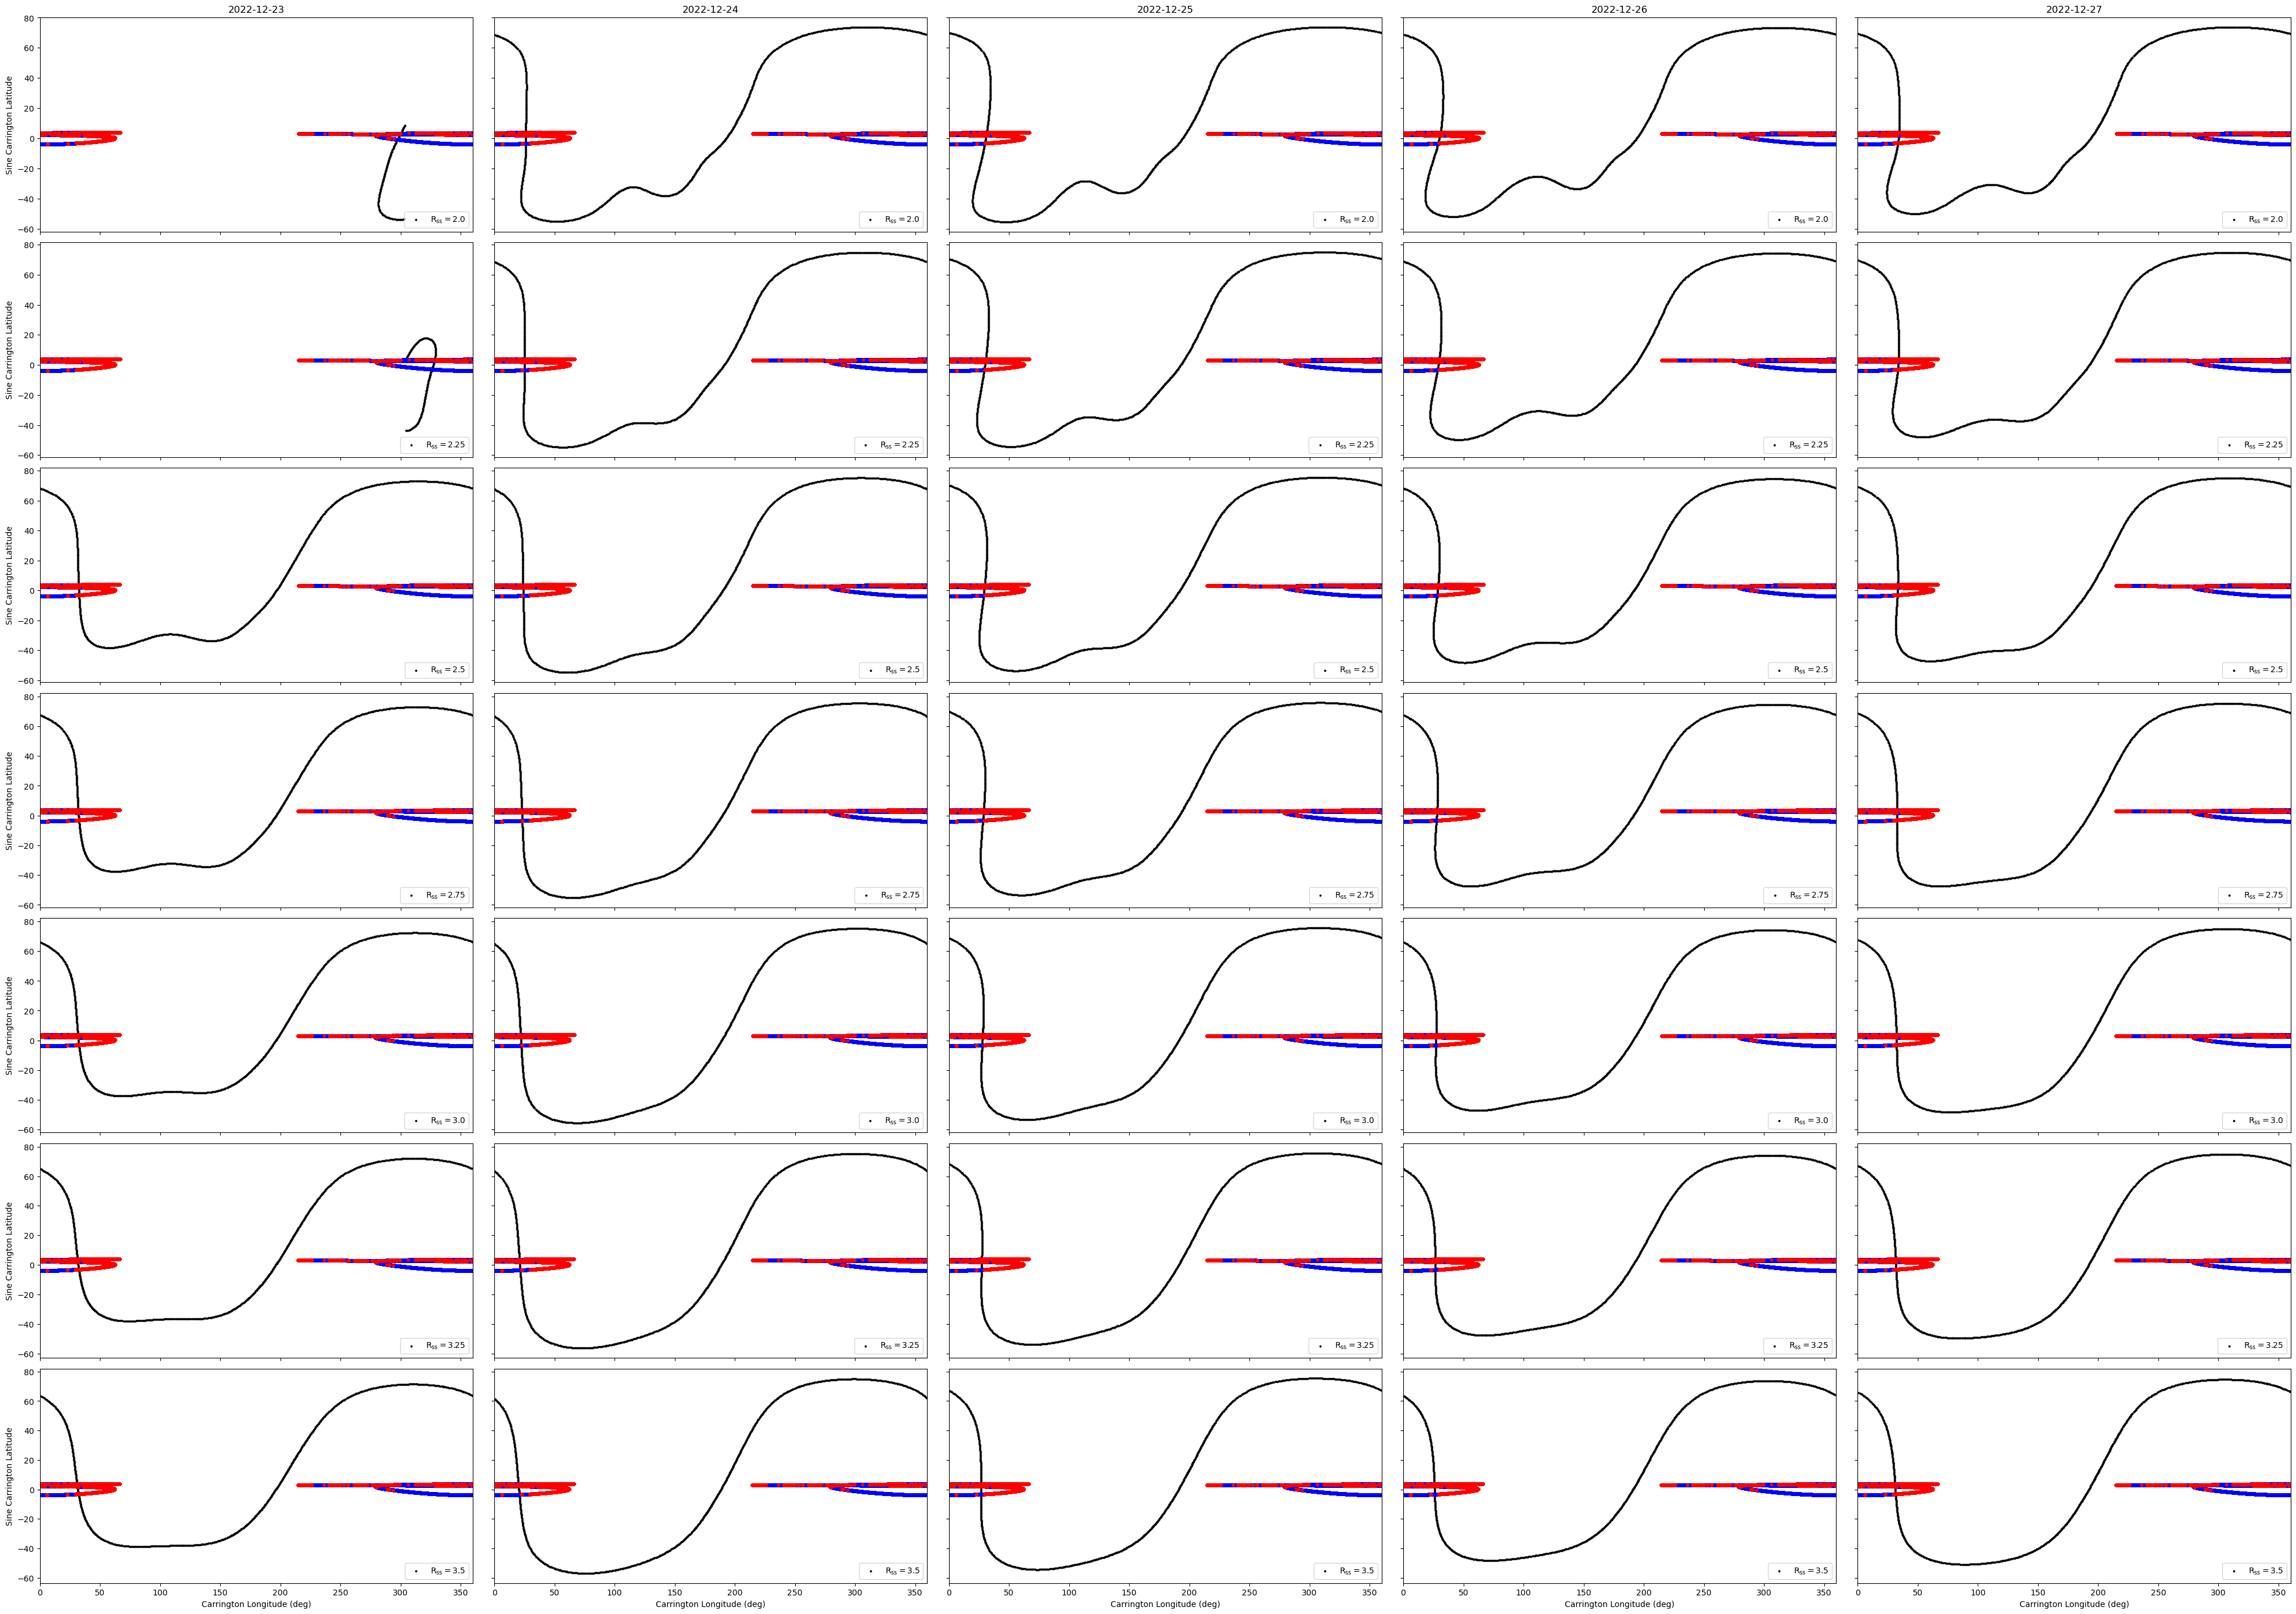

In [11]:
# set up plotting grid
import numpy as np
fig, axs = plt.subplots(7, 5, sharey='row', sharex='col', figsize=[50, 35], gridspec_kw={'hspace': 0.05, 'wspace': 0.05})

for i, h in enumerate(hcs_data):
    head = h.columns[0]
    # for i, h in enumerate(hcs.columns):
    # determine the source surface radius and date
    rss, d = float(head.split('_')[0]), head.split('_')[1]
    lc = str(int(rss))

    # get indices for axs
    j = int((rss/100*4) - 8)
    k = int(i/7)

    # plot the HCS
    # hs = [int(l) - 180 for l in h.iloc[0, :]]
    axs[j, k].scatter(list(h.iloc[0, :]), list(h.iloc[1, :]), color='black', s=3, label= r'$\rm R_{ss} = $' + str(float(rss/100)))

    # plot the PSP trajectory on top of it
    pos = np.where(psp_data.polarity == 1)[0]
    neg = np.where(psp_data.polarity == -1)[0]

    axs[j, k].scatter(coords.loc[:, 'lon_' + lc][neg], coords.loc[:, 'lat_' + lc][neg], color='blue', s=10)
    axs[j, k].scatter(coords.loc[:, 'lon_' + lc][pos], coords.loc[:, 'lat_' + lc][pos], color='red', s=10)

    # set y-label
    if k == 0:
        axs[j, k].set_ylabel("Sine Carrington Latitude")
    
    # set x label
    if j == 6:
        axs[j, k].set_xlabel("Carrington Longitude (deg)")

    # set title (date)
    if j == 0:
        axs[j, k].set_title(d.split('T')[0])

    # set x limit
    axs[j, k].set_xlim(0, 360)
    axs[j, k].legend(loc='lower right')

fig_title = 'e14_predict_comp_low.pdf'
figpath = os.path.join(IMG_DIR, fig_title)
fig.savefig(figpath, dpi=600, bbox_inches='tight')
    

In [ ]:
# get the radial data from stuart
# make the heliospheric current sheet on the 2D grid of Br -- contour where Br at SS is 0
# plot the PSP trajectory across the Br grid 
# use the timeseries from the data on the astrospice thing to get the actual 
#       PSP coordinates for comparison

In [ ]:
# plt.scatter(list(h.iloc[0, :]), list(h.iloc[1, :]))
coords.loc[:, 'lon_' + lc][pos[0]]
# pos[0]

# Prediction/Footpoints
- choose one good magnetogram
- create PFSS model for the magnetogram
- plot CH


In [7]:
# map to 0 at the center
@u.quantity_input
def rollto180(arr:u.deg) : 
    """
    Cast an array of longitudes in the range [0,360] deg to the range
    [-180,180] deg. Useful when examining stuff that crosses through
    Carrington L0.
    """
    return (((arr + 180*u.deg).to("deg").value % 360) - 180)*u.deg

In [9]:
# download/read in magnetogram
local_path = "data/gong"
filename = 'adapt41311_03k012_202212250000_i00005600n1.fts.gz'
filepath = f"{local_path}/{filename}"
rss=2.5
adapt_magnetogram = pfss_funcs.adapt2pfsspy(filepath, return_magnetogram=True)

# run PFSS model
pfss_model = pfss_funcs.adapt2pfsspy(filepath,rss=2.5)

# trace PFSS lines
flines = pfss_funcs.pfss2flines(pfss_model)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


In [10]:
# coronal hole mapping
# high res field lines
flines_highres = pfss_funcs.pfss2flines(pfss_model,nth=181,nph=361)

# get field line topology defined by polarity
topologies = flines_highres.polarities.reshape([181,361])


Text(0.5, 1.0, 'Coronal Hole Map - file=adapt41311_03k012_202212250000_i00005600n1.fts.gz - Rss=2.5Rs')

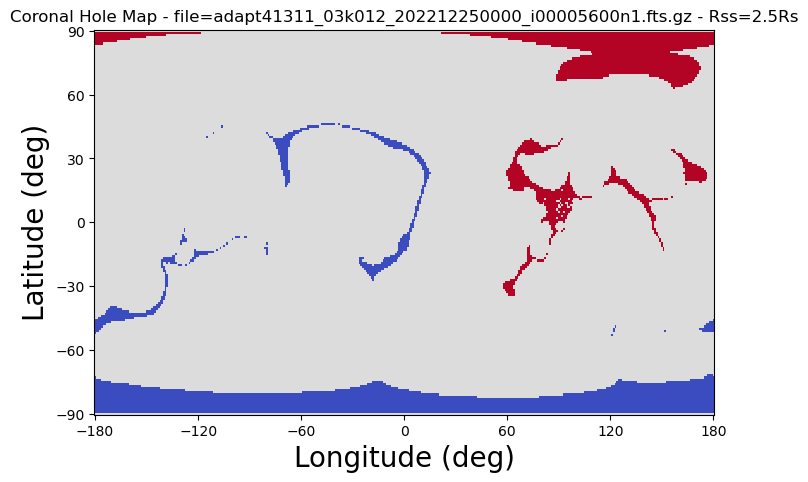

In [11]:
# plot CH map
lons = np.linspace(-180,180,361)
lats = np.linspace(-90,90,181)
fig,ax = plt.subplots(figsize=(8,5))
ax.pcolormesh(lons[181:],lats,topologies[:, :180],cmap="coolwarm")
ax.pcolormesh(lons[:181],lats,topologies[:, 180:],cmap="coolwarm")
ax.set_xlabel("Longitude (deg)",fontsize=20)
ax.set_ylabel("Latitude (deg)",fontsize=20)
ax.set_xticks(np.linspace(-180,180,7))
ax.set_yticks(np.linspace(-90,90,7))
ax.set_title(f"Coronal Hole Map - file={filename} - Rss=2.5Rs")

# fig_title = str(pfss_br.date) + '_CH_' + str(rss) + '.png'
# figpath = os.path.join(IMG_DIR, fig_title)
# fig.savefig(figpath, dpi=1200, bbox_inches='tight')

In [14]:
# psp_coords_carr = psp_funcs.get_psp_coords(psp_data.date_obj)
import astrospice

kernels = astrospice.registry.get_kernels('psp', 'predict')
psp_coords_inertial = astrospice.generate_coords('SOLAR PROBE PLUS', psp_data.date_obj)

# Transform to Heliographic Carrington, i.e. the frame that co-rotates with the Sun.
psp_coords_carr = psp_coords_inertial.transform_to(
sunpy.coordinates.HeliographicCarrington(observer="self"))

# get psp at source surface
psp_at_source_surface = psp_funcs.coord_projection(psp_coords_carr, rss, psp_data.date_obj)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

NameError: name 'psp_data' is not defined

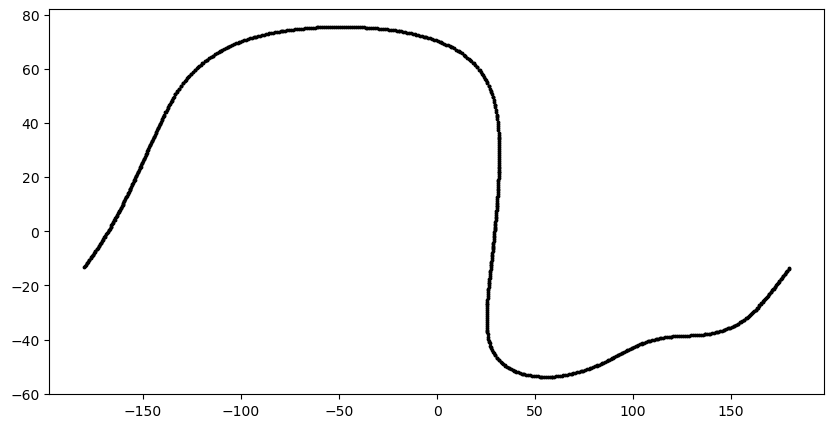

In [12]:
# map to 0 at the center
@u.quantity_input
def rollto180(arr:u.deg) : 
    """
    Cast an array of longitudes in the range [0,360] deg to the range
    [-180,180] deg. Useful when examining stuff that crosses through
    Carrington L0.
    """
    return (((arr + 180*u.deg).to("deg").value % 360) - 180)*u.deg

# get Br at the source surface from the pfss model
pfss_br = pfss_model.source_surface_br

# get HCS
hcs = pfss_model.source_surface_pils[0]

# plot this using sunpy
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
# pfss_br.plot(axes=ax)

# plot the HCS
ax.scatter(rollto180(hcs.lon), rollto180(hcs.lat), color='black', s=3, label='HCS')

# plot the PSP trajectory on top of it
pos = np.where(psp_data.polarity == 1)
neg = np.where(psp_data.polarity == -1)

ax.scatter(rollto180(psp_at_source_surface.lon[neg]), rollto180(psp_at_source_surface.lat[neg]), color='blue', s=10,
label='Negative Polarity')
ax.scatter(rollto180(psp_at_source_surface.lon[pos]), rollto180(psp_at_source_surface.lat[pos]), color='red', s=10, 
label='Positive Polarity')

ax.set_title(str(pfss_br.date)[:-4] + r" $\rm R_{ss} =$" + str(rss))
ax.set_xlabel("Carrington Longitude [deg]")
ax.set_ylabel("Carrington Latitude [deg]")

ax.set_xlim(-180,180)
ax.legend(loc='lower right')

fig_title = str(pfss_br.date) + '_' + str(rss) + '.png'
figpath = os.path.join(IMG_DIR, fig_title)
fig.savefig(figpath, dpi=1200, bbox_inches='tight')


# Field Line Tracer
- plot CH map
- plot HCS
- plot trajectory
- pfss2flines to link trajectory to CH

In [15]:
# get Br at the source surface from the pfss model
pfss_br = pfss_model.source_surface_br

# get HCS
hcs = pfss_model.source_surface_pils[0]

# get trajectory 
pos = np.where(psp_data.polarity == 1)
neg = np.where(psp_data.polarity == -1)

# get field lines
flines_psp = pfss_funcs.pfss2flines(pfss_model, skycoord_in=psp_at_source_surface)

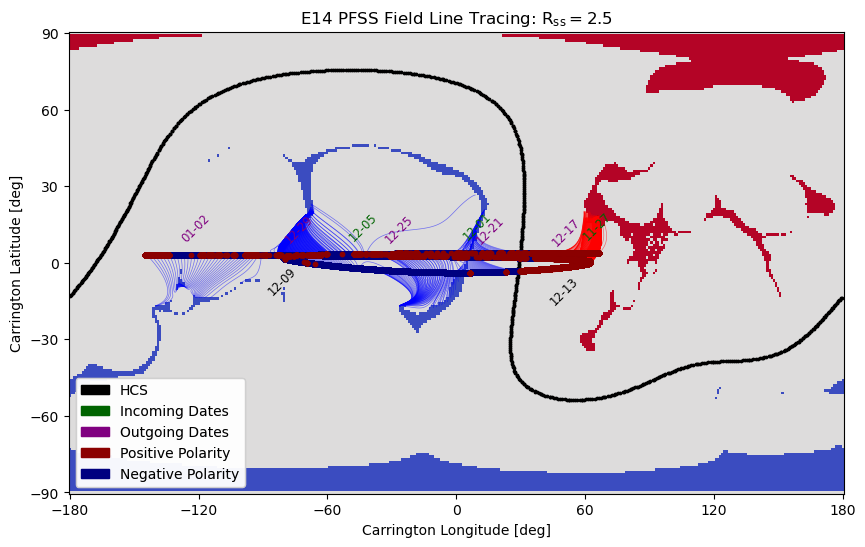

In [89]:
# color dictionary
color_dict = {-1:"blue", 0:"black", 1:"red"}

# plot CH map
lons = np.linspace(-180,180,361)
lats = np.linspace(-90,90,181)
fig,ax = plt.subplots(figsize=(10, 6))
ax.pcolormesh(lons[181:],lats,topologies[:, :180],cmap="coolwarm", zorder=-1)
ax.pcolormesh(lons[:181],lats,topologies[:, 180:],cmap="coolwarm", zorder=-1)

# plot HCS
ax.scatter(rollto180(hcs.lon), rollto180(hcs.lat), color='black', s=3, label='HCS', zorder=0)

# plot field lines
for f in flines_psp[::216] :
    fcoords = f.coords
    fcoords.representation_type="spherical"
    ax.plot(rollto180(fcoords.lon),
            rollto180(fcoords.lat),
            # fcoords.z.to("R_sun"),
            color = color_dict.get(f.polarity), 
            linewidth=0.5, alpha=0.5, zorder=1
           )

# plot trajectory
ax.scatter(rollto180(psp_at_source_surface.lon[neg]), rollto180(psp_at_source_surface.lat[neg]), color='navy', s=10,
label='Negative Polarity', zorder=2)
ax.scatter(rollto180(psp_at_source_surface.lon[pos]), rollto180(psp_at_source_surface.lat[pos]), color='darkred', s=10, 
label='Positive Polarity', zorder=3)

# plot dates
# plot_dates = ['2022-11-27', '2022-12-01', '2022-12-05', '2022-12-09', '2022-12-11', '2022-12-13', '2022-12-17', '2022-12-21', '2022-12-25', '2022-12-29',
# '2022-01-01', '2022-01-04']
psp_inds = [np.where(psp_data.date == d)[0][0] for d in np.unique(psp_data.date)[0::4]]
for i, x in enumerate(list(zip(rollto180(psp_at_source_surface.lon[psp_inds]), rollto180(psp_at_source_surface.lat[psp_inds])))):
    label = np.unique(psp_data.date)[0::4][i]
    if i <3:
        # ax.annotate(label[-5:], (x[0].value, x[1].value), textcoords="offset points", xytext=(-1, 6), ha='center', fontsize='8', rotation=45, 
        # bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3), zorder=4)
        ax.text(x[0].value - 1, x[1].value + 4, label[-5:], ha="center", va="bottom", color="darkgreen", rotation=45, size='small', label='Incoming', zorder=5)
    elif 3 <= i < 5:
        ax.text(x[0].value - 1, x[1].value - 16, label[-5:], ha="center", va="bottom", color="black", rotation=45, size='small', zorder=5)
        # ax.annotate(label[-5:], (x[0].value, x[1].value), textcoords="offset points", xytext=(-1, -20), ha='center', fontsize='8', rotation=45, zorder=4)
    else:
        ax.text(x[0].value - 1, x[1].value + 4, label[-5:], ha="center", va="bottom", size="small", color="purple", rotation=45, label='Outgoing', zorder=5)


# legend
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
inc = mpatches.Patch(color='darkgreen', label='Incoming Dates')
out = mpatches.Patch(color='purple', label='Outgoing Dates')
red_patch = mpatches.Patch(color='darkred', label='Positive Polarity')
blue_patch = mpatches.Patch(color='navy', label='Negative Polarity')
hcs_patch = mpatches.Patch(color='black', label='HCS')

leg1 = ax.legend(handles=[hcs_patch, inc, out, red_patch, blue_patch], loc='lower left')

ax.add_artist(leg1)

# title and labels
ax.set_title('E14 PFSS Field Line Tracing:' + r" $\rm R_{ss} =$" + str(rss))
ax.set_xticks(np.linspace(-180,180,7))
ax.set_yticks(np.linspace(-90,90,7))
ax.set_xlabel("Carrington Longitude [deg]")
ax.set_ylabel("Carrington Latitude [deg]")

fig_title = 'E14_PFSS_FieldLines_' + str(rss) + '.png'
figpath = os.path.join(IMG_DIR, fig_title)
fig.savefig(figpath, dpi=1200, bbox_inches='tight')

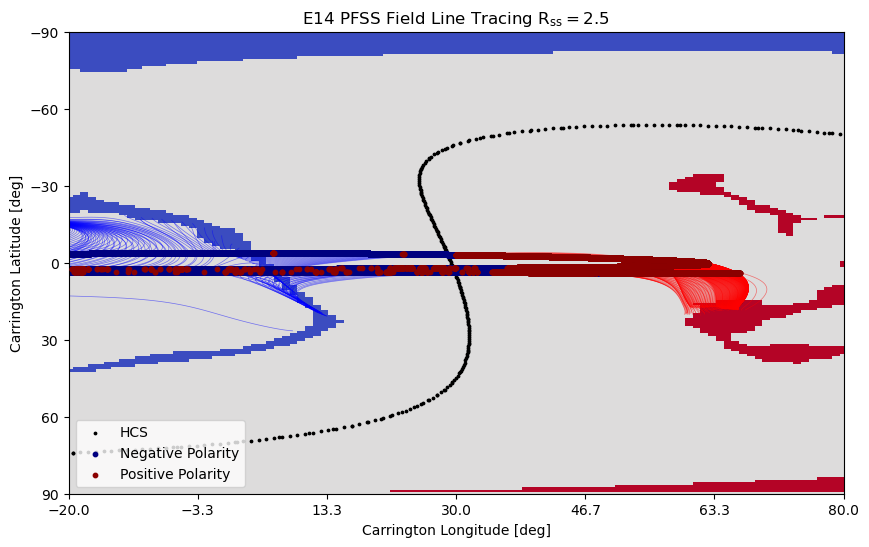

In [88]:
# zoom in on longitude
# color dictionary
color_dict = {-1:"blue", 0:"black", 1:"red"}

# plot CH map
lons = np.linspace(-180,180,361)
lats = np.linspace(-90,90,181)
fig,ax = plt.subplots(figsize=(10, 6))
ax.pcolormesh(lons[181:],lats,topologies[:, :180],cmap="coolwarm", zorder=-1)
ax.pcolormesh(lons[:181],lats,topologies[:, 180:],cmap="coolwarm", zorder=-1)

# plot HCS
ax.scatter(rollto180(hcs.lon), rollto180(hcs.lat), color='black', s=3, label='HCS', zorder=0)

# plot field lines
for f in flines_psp[::216] :
    fcoords = f.coords
    fcoords.representation_type="spherical"
    ax.plot(rollto180(fcoords.lon),
            rollto180(fcoords.lat),
            # fcoords.z.to("R_sun"),
            color = color_dict.get(f.polarity), 
            linewidth=0.5, alpha=0.5, zorder=1
           )

# plot dates
plot_dates = ['2022-11-27', '2022-12-01', '2022-12-05', '2022-12-09', '2022-12-11', '2022-12-13', '2022-12-17', '2022-12-21', '2022-12-25', '2022-12-29',
'2022-01-01', '2022-01-04']
psp_inds = [np.where(psp_data.date == d)[0][0] for d in np.unique(psp_data.date)[0::4]]
# for i, x in enumerate(list(zip(rollto180(psp_at_source_surface.lon[psp_inds]), rollto180(psp_at_source_surface.lat[psp_inds])))):
#     label = np.unique(psp_data.date)[0::4][i]
#     if i <3:
#         # ax.annotate(label[-5:], (x[0].value, x[1].value), textcoords="offset points", xytext=(-1, 6), ha='center', fontsize='8', rotation=45, 
#         # bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3), zorder=4)
#         ax.text(x[0].value - 1, x[1].value + 4, label[-5:], ha="center", va="bottom", color="darkgreen", rotation=45, size='small', zorder=5)
#     elif 3 <= i < 5:
#         ax.text(x[0].value - 1, x[1].value - 16, label[-5:], ha="center", va="bottom", color="black", rotation=45, size='small')
#         # ax.annotate(label[-5:], (x[0].value, x[1].value), textcoords="offset points", xytext=(-1, -20), ha='center', fontsize='8', rotation=45, zorder=4)
#     else:
#         ax.text(x[0].value - 1, x[1].value + 4, label[-5:], ha="center", va="bottom", size="small", color="purple", rotation=45, zorder=5)
#         # ax.annotate(label[-5:], (x[0].value, x[1].value), textcoords="offset points", xytext=(-1, -20), ha='center', fontsize='8', rotation=45, zorder=4)

# plot trajectory
ax.scatter(rollto180(psp_at_source_surface.lon[neg]), rollto180(psp_at_source_surface.lat[neg]), color='navy', s=10,
label='Negative Polarity', zorder=2)
ax.scatter(rollto180(psp_at_source_surface.lon[pos]), rollto180(psp_at_source_surface.lat[pos]), color='darkred', s=10, 
label='Positive Polarity', zorder=3)

# add legend
ax.set_xlim(-20, 80)
ax.set_ylim(np.sin(-5), np.sin(5))
ax.legend(loc='lower left')

# title and labels
ax.set_title('E14 PFSS Field Line Tracing' + r" $\rm R_{ss} =$" + str(rss))
ax.set_xticks(np.linspace(-20,80,7))
ax.set_yticks(np.linspace(-90,90,7))
ax.set_xlabel("Carrington Longitude [deg]")
ax.set_ylabel("Carrington Latitude [deg]")

fig_title = 'E14_PFSS_FieldLines_CH_' + str(rss) + '.png'
figpath = os.path.join(IMG_DIR, fig_title)
fig.savefig(figpath, dpi=1200, bbox_inches='tight')